In [1]:
import pickle
with open('ROMS_26yr_daydic.pkl', 'rb') as file:
    daydic = pickle.load(file)

with open('ROMS_26yr_eddies.pkl', 'rb') as file:
    eddies = pickle.load(file)

with open('/srv/scratch/z5297792/Sample/frontier_sample_data.pkl', 'rb') as file:
    sample_data = pickle.load(file)
the_frontier_eddies = list(sample_data.keys())

In [2]:
import netCDF4 as nc
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt
from scipy.interpolate import griddata
import time

fname = '/srv/scratch/z3533156/26year_BRAN2020/outer_avg_01461.nc'
dataset = nc.Dataset(fname)
lon_rho  = dataset.variables['lon_rho'][:]
lon_rho = np.transpose(lon_rho, axes=(1, 0))
lat_rho  = dataset.variables['lat_rho'][:]
lat_rho = np.transpose(lat_rho, axes=(1, 0))
f  = dataset.variables['f'][:]
f = np.transpose(f, axes=(1, 0))
h = dataset.variables['h'][:]
h = np.transpose(h, axes=(1, 0))
z_r = np.load('/home/z5297792/UNSW-MRes/MRes/z_r/z_r.npy')
z_r = np.transpose(z_r, (1, 2, 0))
temp_ave = np.load('/srv/scratch/z5297792/Climatology/temp_ave.npy')
CurSpeed_ave = np.load('/srv/scratch/z5297792/Climatology/CurSpeed_ave.npy')

In [3]:
def calc_ow(uu, vv, dx, dy):
    WIDTH, LENGTH, SIGMAS = uu.shape
    u_x = (uu[2:,:,:] - uu[:-2,:,:]) / (2*dx)
    u_y = (uu[:,2:,:] - uu[:,:-2,:]) / (2*dy)
    v_x = (vv[2:,:,:] - vv[:-2,:,:]) / (2*dx)
    v_y = (vv[:,2:,:] - vv[:,:-2,:]) / (2*dy)
    u_x = np.concatenate((np.zeros((1, LENGTH, SIGMAS)), u_x, np.zeros((1, LENGTH, SIGMAS))), axis=0)
    v_x = np.concatenate((np.zeros((1, LENGTH, SIGMAS)), v_x, np.zeros((1, LENGTH, SIGMAS))), axis=0)
    u_y = np.concatenate((np.zeros((WIDTH, 1, SIGMAS)), u_y, np.zeros((WIDTH, 1, SIGMAS))), axis=1)
    v_y = np.concatenate((np.zeros((WIDTH, 1, SIGMAS)), v_y, np.zeros((WIDTH, 1, SIGMAS))), axis=1)
    s_n = u_x - v_y
    s_s = v_x + u_y
    vort = v_x - u_y
    ow = s_n**2 + s_s**2 - vort**2
    return ow
    
def normalize_matrix(matrix, mask_value=np.nan):
    valid_mask = np.where(matrix == mask_value, 0, 1)
    valid_mean = np.nansum(matrix) / np.sum(valid_mask)
    valid_std = np.sqrt(np.nansum(valid_mask * (matrix - valid_mean) ** 2) / np.sum(valid_mask))
    return (matrix - valid_mean) / valid_std


In [4]:
CS_THRESH = 0.05
OW_THRESH = -0.2
RATIO_THRESH = 1/3
SEARCH_RADIUS_MAX = 50000

eddy = the_frontier_eddies[0]
t = 15

U = sample_data[eddy]['T'+str(t)]['U']
V = sample_data[eddy]['T'+str(t)]['V']
x = sample_data[eddy]['T'+str(t)]['x']
y = sample_data[eddy]['T'+str(t)]['y']
X, Y = np.meshgrid(x, y)

cs = np.sqrt(U**2 + V**2)
ow = normalize_matrix(calc_ow(U, V, x[1]-x[0], x[1]-x[0]))

xc, yc = 0, 0
xcs, ycs, zcs = [], [], []
A = np.array([[np.nan, np.nan], [np.nan, np.nan]])
bottom_flag = 0
depth_dic = {}
for depth_lvl in range(U.shape[-1]):
    Search_Radius = 5000
    flag = 0
    if not bottom_flag:
        while Search_Radius <= SEARCH_RADIUS_MAX:
            R = np.sqrt((X - xc)**2 + (Y - yc)**2)
            mask = R < Search_Radius
            cur_speed_masked = np.where(mask, cs[:, :, depth_lvl], np.nan) 
            ow_masked = np.where(mask, ow[:, :, depth_lvl], np.nan) 
            pot_i, pot_j = np.where((cur_speed_masked < CS_THRESH) & (ow_masked < OW_THRESH))
            ratio = len(pot_i) / np.sum(mask) if len(pot_i) != 0 else 0
            if ratio <= RATIO_THRESH and ratio != 0:
                A = np.array([x[pot_i], y[pot_j]])
                xc, yc = np.mean(A, axis=1)
                xcs.append(xc)
                ycs.append(yc)
                zcs.append(z_r[150, 150, depth_lvl])
                depth_dic['Depth'+str(depth_lvl)] = {'xc': xc, 'yc': yc, 
                                                     'Depth': z_r[150, 150, depth_lvl],
                                                     'pots': A, 'SR': Search_Radius
                                                    }
                flag = 1
                break
            Search_Radius += 5000
        if not flag:
            bottom_flag = 1
xcs, ycs, zcs = np.array(xcs), np.array(ycs), np.array(zcs)

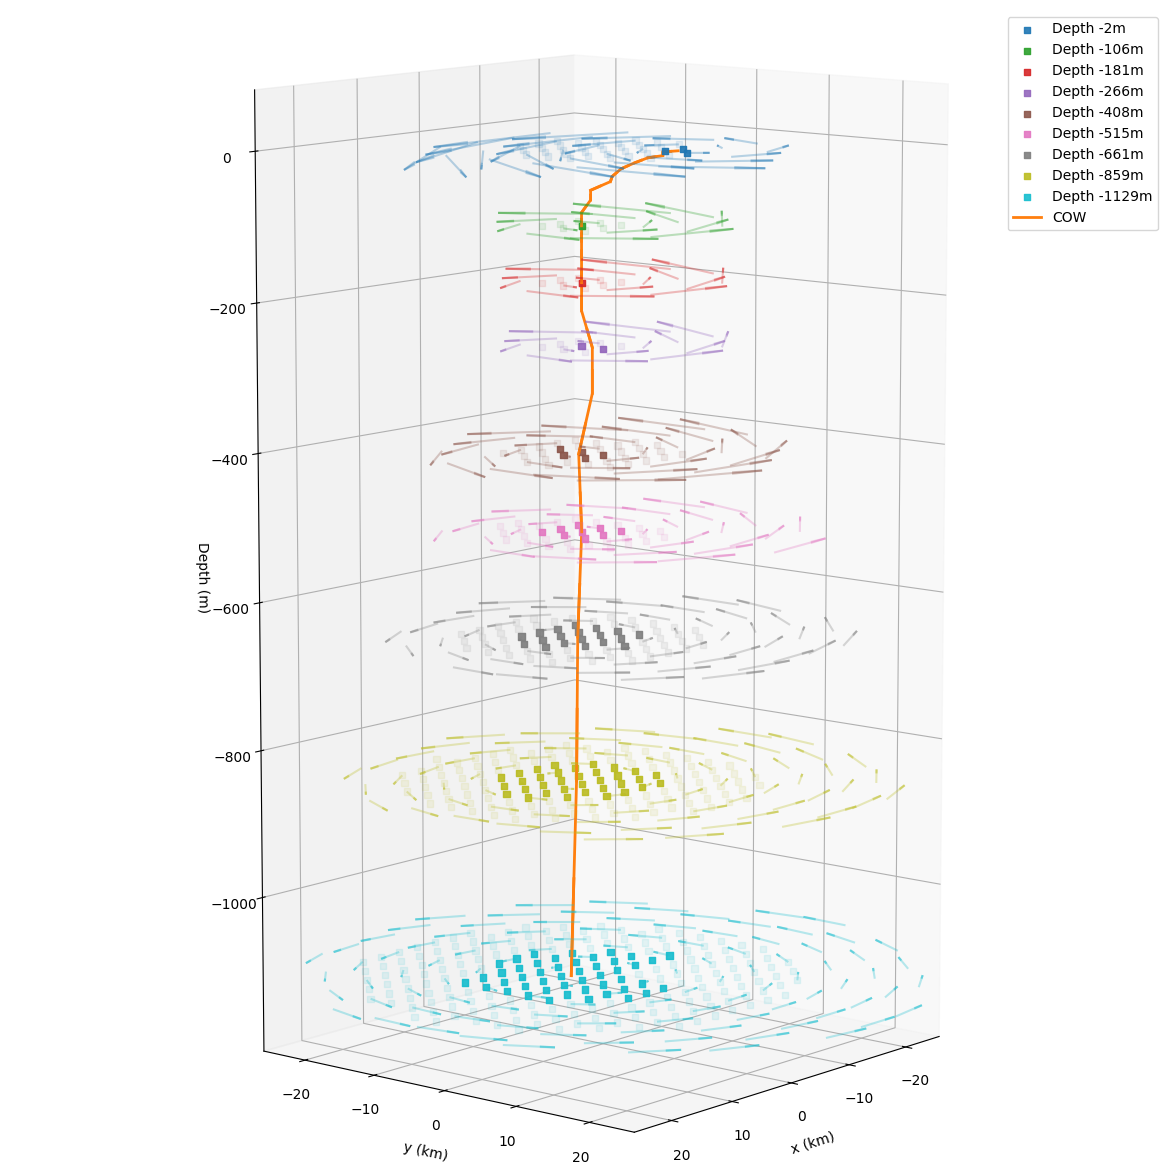

In [5]:
from mpl_toolkits.mplot3d import Axes3D  

X, Y = np.meshgrid(x/1000, y/1000)

fig = plt.figure(figsize=(15, 15))
ax = fig.add_subplot(111, projection='3d')
colors = plt.cm.tab10.colors * 3
# for i, depth_lvl in enumerate(idx for idx in range(len(depth_dic)) if idx not in [1,2,3,4, 5,6, 7,8, 9, 11, 17, 15, 13, 12]):
for i, depth_lvl in enumerate([0,11,14,16,18,19,20,21,22]):
# for i, depth_lvl in enumerate(range(len(depth_dic))):
    if i > 0:
        i += 1
    data = depth_dic['Depth' + str(depth_lvl)]
    A = data['pots']/1000
    xc = data['xc']/1000
    yc = data['yc']/1000
    z = data['Depth']
    SR = data['SR']/1000
    if depth_lvl == 0:
        xc_pre, yc_pre = 0, 0
    else:
        pre_data = depth_dic['Depth' + str(depth_lvl-1)]
        xc_pre, yc_pre = pre_data['xc']/1000, pre_data['yc']/1000
    R = np.hypot(X-xc_pre, Y-yc_pre)
    X_masked = np.where(R < SR, X, np.nan)
    Y_masked = np.where(R < SR, Y, np.nan)
    ax.scatter(X_masked, Y_masked, [z] * (X_masked.shape[0]*X_masked.shape[1]), marker='s', alpha=0.1, color=colors[i]) 
    ax.scatter(A[0, :], A[1, :], [z] * len(A[0, :]), marker='s', alpha=0.9, color=colors[i], label=f'Depth {round(z_r[150,150,depth_lvl])}m') 

    spacing = 2
    scale_factor = 50
    # quiver_radius = 30
    # R = np.hypot(X-xc, Y-yc)
    u_masked = np.where(R < SR+10, U[:,:,depth_lvl], np.nan)
    v_masked = np.where(R < SR+10, V[:,:,depth_lvl], np.nan)

    u, v = u_masked[::spacing, ::spacing].T * scale_factor, v_masked[::spacing, ::spacing].T * scale_factor
    XX, YY = X[::spacing, ::spacing], Y[::spacing, ::spacing]
    ax.quiver(XX, YY, z * np.ones_like(XX), u, v, np.zeros_like(u), color=colors[i], alpha=.3, zorder=0)


ax.plot(xcs/1000, ycs/1000, zcs, zorder=1, linewidth=2, color=colors[1], label='COW')
for i in range(1, len(xcs)):
    x_mid = (xcs[i]+xcs[i-1])/2 / 1000
    y_mid = (ycs[i]+ycs[i-1])/2 / 1000
    z_mid = (zcs[i]+zcs[i-1])/2 
    ax.plot([xcs[i]/1000, x_mid], [ycs[i]/1000, y_mid], [zcs[i], z_mid], linewidth=2, color=colors[1],zorder=10)
    
ax.view_init(elev=10, azim=40) #350
ax.set_box_aspect([1, 1, 2]) 
ax.set_xlabel("x (km)")
ax.set_ylabel("y (km)")
ax.set_zlabel("Depth (m)", labelpad=15)
ax.set_xlim([-25, 25])
ax.set_ylim([-25, 25])
ax.legend()
ax.tick_params(axis='z', direction='in', length=6, pad=10)  # Adjust 'pad' value for left/right positioning
plt.show()

Number of groups: 33
Group sizes: [    4    23    11     1     1     1     3    11    13    15   117     1
     1     1    58   954     8     5     5    58     1     1    71    13
    59 10842     4   327    65   343    14   380    45]
Largest group ID: 26, Size: 10842


/scratch/pbs.6060951.kman.restech.unsw.edu.au/ipykernel_3625440/3545154806.py:69: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_xticklabels([str(round(a/1000)) for a in x[xticks]])
/scratch/pbs.6060951.kman.restech.unsw.edu.au/ipykernel_3625440/3545154806.py:70: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_yticklabels([str(round(b/1000)) for b in y[yticks]])
/scratch/pbs.6060951.kman.restech.unsw.edu.au/ipykernel_3625440/3545154806.py:71: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_zticklabels([str(round(c)) for c in z_new[zticks]])
/scratch/pbs.6060951.kman.restech.unsw.edu.au/ipykernel_3625440/3545154806.py:88: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks

[Text(34.0, 0, '-1551'),
 Text(36.0, 0, '-1357'),
 Text(38.0, 0, '-1163'),
 Text(40.0, 0, '-969'),
 Text(42.0, 0, '-775'),
 Text(44.0, 0, '-582'),
 Text(46.0, 0, '-388'),
 Text(48.0, 0, '-194'),
 Text(50.0, 0, '0')]

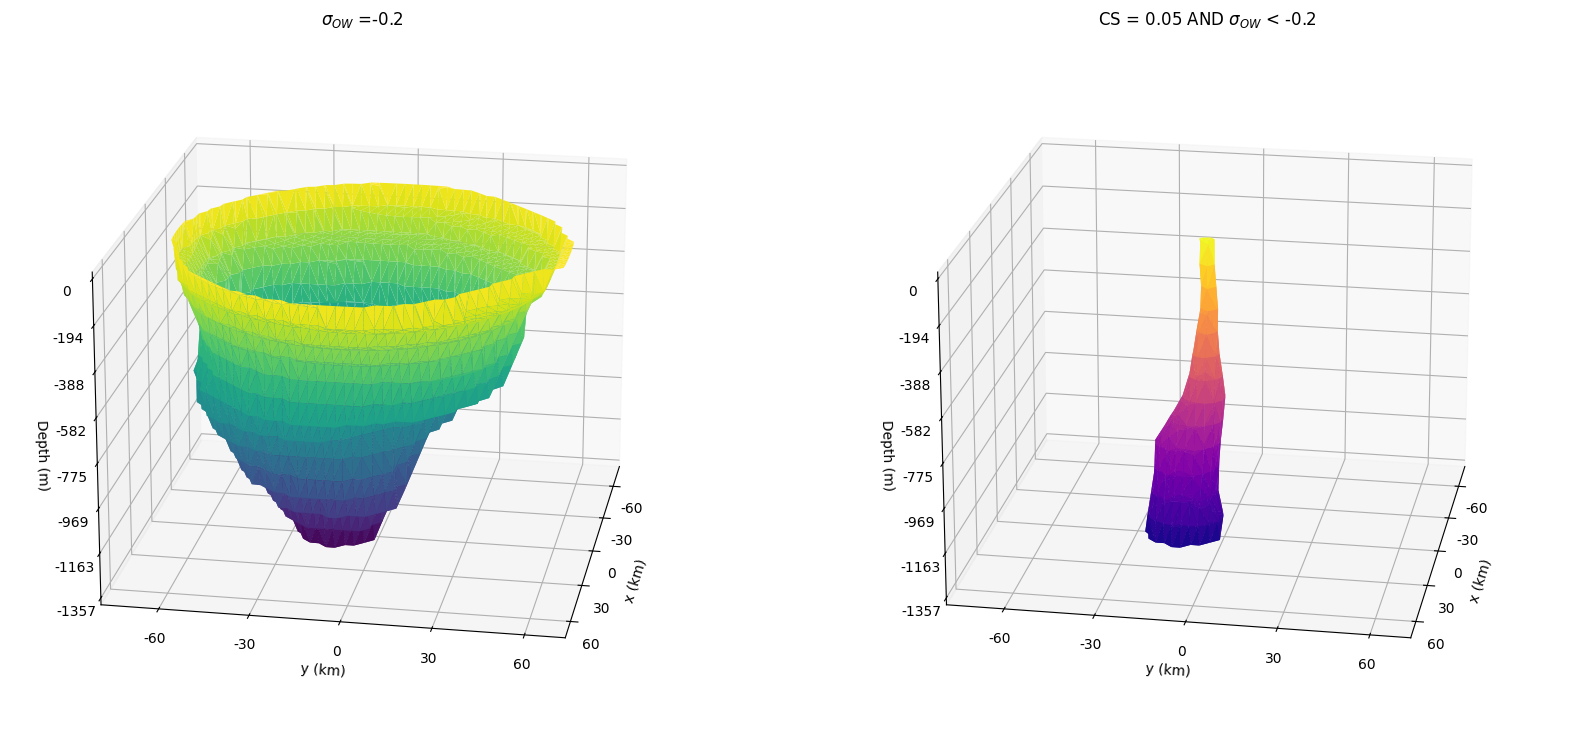

In [6]:
from skimage import measure
from scipy.interpolate import interp1d
from scipy.ndimage import label

eddy = the_frontier_eddies[0]
t = 20

U = sample_data[eddy]['T'+str(t)]['U']
V = sample_data[eddy]['T'+str(t)]['V']
x = sample_data[eddy]['T'+str(t)]['x']
y = sample_data[eddy]['T'+str(t)]['y']
z = z_r[150,150,:V.shape[-1]]

cs = np.sqrt(U**2 + V**2)
ow = normalize_matrix(calc_ow(U, V, x[1]-x[0], x[1]-x[0]))

z_layers = 50
z_new = np.flip(np.linspace(z[-1], 0, z_layers))

ow_interpolated = np.empty((ow.shape[0], ow.shape[1], len(z_new)))
for i in range(ow.shape[0]):
    for j in range(ow.shape[1]):
        f = interp1d(z, ow[i, j, :], kind='linear', bounds_error=False, fill_value='extrapolate')
        ow_interpolated[i, j, :] = f(z_new)
cs_interpolated = np.empty((cs.shape[0], cs.shape[1], len(z_new)))
for i in range(cs.shape[0]):
    for j in range(cs.shape[1]):
        f = interp1d(z, cs[i, j, :], kind='linear', bounds_error=False, fill_value='extrapolate')
        cs_interpolated[i, j, :] = f(z_new)

X, Y, Z = np.linspace(x[0]/1000, x[-1]/1000, z_layers), np.linspace(y[0]/1000, y[-1]/1000, z_layers), z_new

elev, azim = 20, 10

OW_THRESH = -.2

mask = ow_interpolated <= OW_THRESH

structure = np.ones((3, 3, 3), dtype=int)  
labeled_groups, num_groups = label(mask, structure=structure)
print(f"Number of groups: {num_groups}")
group_sizes = np.array([np.sum(labeled_groups == i) for i in range(1, num_groups + 1)])
print(f"Group sizes: {group_sizes}")
largest_group_id = np.argmax(group_sizes) + 1  # Group IDs start from 1
print(f"Largest group ID: {largest_group_id}, Size: {group_sizes[largest_group_id - 1]}")

largest_group_mask = labeled_groups == largest_group_id
# Mask everything but the largest group in the original data
ow_interpolated_masked = np.where(largest_group_mask, ow_interpolated, 1) 

fig = plt.figure(figsize=(20,20))
ax1 = fig.add_subplot(121, projection='3d')
verts, faces, _, _ = measure.marching_cubes(np.flip(ow_interpolated_masked, axis=2), OW_THRESH)
ax1.plot_trisurf(verts[:, 0], verts[:, 1], verts[:, 2], triangles=faces, cmap='viridis', lw=1)
ax1.set_xlabel('x (km)')
ax1.set_ylabel('y (km)')
ax1.set_zlabel('Depth (m)')
ax1.set_title(r'$\sigma_{OW}$ ='+str(OW_THRESH))
ax1.view_init(elev=elev, azim=azim)
xlim = ax1.get_xlim()
ylim = ax1.get_ylim()
zlim = ax1.get_zlim()
ax1.set_zlim([np.min(zlim), 50])
zlim = ax1.get_zlim()

xticks = [int(a)-1 for a in ax1.get_xaxis().get_ticklocs()]
yticks = [int(b)-1 for b in ax1.get_yaxis().get_ticklocs()]
zticks = [z_layers - (int(c)) for c in ax1.get_zaxis().get_ticklocs()]
ax1.set_xticklabels([str(round(a/1000)) for a in x[xticks]])
ax1.set_yticklabels([str(round(b/1000)) for b in y[yticks]])
ax1.set_zticklabels([str(round(c)) for c in z_new[zticks]])

cs_interpolated_masked = np.where(largest_group_mask, cs_interpolated, 10)

CS_THRESH = .05
ax2 = fig.add_subplot(122, projection='3d')
verts, faces, _, _ = measure.marching_cubes(np.flip(cs_interpolated_masked, axis=2), CS_THRESH)
ax2.plot_trisurf(verts[:, 0], verts[:, 1], verts[:, 2], triangles=faces, cmap='plasma', lw=1)
ax2.set_xlabel('x (km)')
ax2.set_ylabel('y (km)')
ax2.set_zlabel('Depth (m)')
ax2.set_title(r'CS = '+str(CS_THRESH)+' AND $\sigma_{OW}$ < '+str(OW_THRESH))
ax2.view_init(elev=elev, azim=azim)
ax2.set_xlim(xlim)  
ax2.set_ylim(ylim)  
ax2.set_zlim(zlim)  

ax2.set_xticklabels([str(round(a/1000)) for a in x[xticks]])
ax2.set_yticklabels([str(round(b/1000)) for b in y[yticks]])
ax2.set_zticklabels([str(round(c)) for c in z_new[zticks]])



Number of groups: 41
Group sizes: [    1     2    17    55     1    13     5     1     3     3     1     1
     1     1     1     1    30    61    98    31    56    13    17    11
   121 10856   135     2     1     7    51    64   151   128     2     4
     1   844   215   469    12]
Largest group ID: 26, Size: 10856


/scratch/pbs.6060951.kman.restech.unsw.edu.au/ipykernel_3625440/1674900293.py:69: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_xticklabels([str(round(a/1000)) for a in x[xticks]])
/scratch/pbs.6060951.kman.restech.unsw.edu.au/ipykernel_3625440/1674900293.py:70: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_yticklabels([str(round(b/1000)) for b in y[yticks]])
/scratch/pbs.6060951.kman.restech.unsw.edu.au/ipykernel_3625440/1674900293.py:71: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_zticklabels([str(round(c)) for c in z_new[zticks]])
/scratch/pbs.6060951.kman.restech.unsw.edu.au/ipykernel_3625440/1674900293.py:88: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks

[Text(34.0, 0, '-1551'),
 Text(36.0, 0, '-1357'),
 Text(38.0, 0, '-1163'),
 Text(40.0, 0, '-969'),
 Text(42.0, 0, '-775'),
 Text(44.0, 0, '-582'),
 Text(46.0, 0, '-388'),
 Text(48.0, 0, '-194'),
 Text(50.0, 0, '0')]

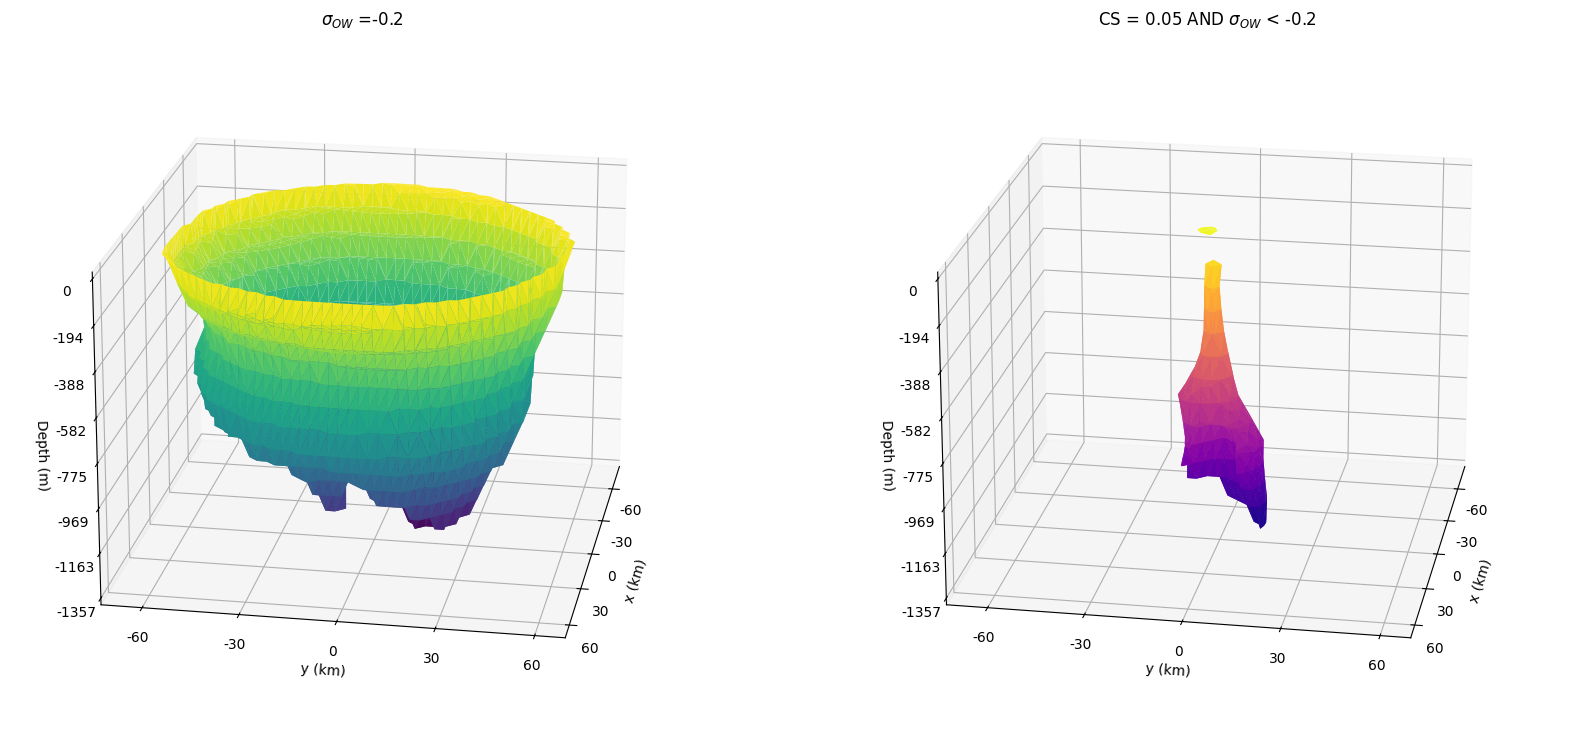

In [25]:
from skimage import measure
from scipy.interpolate import interp1d
from scipy.ndimage import label

eddy = the_frontier_eddies[0]
t = 29

U = sample_data[eddy]['T'+str(t)]['U']
V = sample_data[eddy]['T'+str(t)]['V']
x = sample_data[eddy]['T'+str(t)]['x']
y = sample_data[eddy]['T'+str(t)]['y']
z = z_r[150,150,:V.shape[-1]]

cs = np.sqrt(U**2 + V**2)
ow = normalize_matrix(calc_ow(U, V, x[1]-x[0], x[1]-x[0]))

z_layers = 50
z_new = np.flip(np.linspace(z[-1], 0, z_layers))

ow_interpolated = np.empty((ow.shape[0], ow.shape[1], len(z_new)))
for i in range(ow.shape[0]):
    for j in range(ow.shape[1]):
        f = interp1d(z, ow[i, j, :], kind='linear', bounds_error=False, fill_value='extrapolate')
        ow_interpolated[i, j, :] = f(z_new)
cs_interpolated = np.empty((cs.shape[0], cs.shape[1], len(z_new)))
for i in range(cs.shape[0]):
    for j in range(cs.shape[1]):
        f = interp1d(z, cs[i, j, :], kind='linear', bounds_error=False, fill_value='extrapolate')
        cs_interpolated[i, j, :] = f(z_new)

X, Y, Z = np.linspace(x[0]/1000, x[-1]/1000, z_layers), np.linspace(y[0]/1000, y[-1]/1000, z_layers), z_new

elev, azim = 20, 10

OW_THRESH = -.2

mask = ow_interpolated <= OW_THRESH

structure = np.ones((3, 3, 3), dtype=int)  
labeled_groups, num_groups = label(mask, structure=structure)
print(f"Number of groups: {num_groups}")
group_sizes = np.array([np.sum(labeled_groups == i) for i in range(1, num_groups + 1)])
print(f"Group sizes: {group_sizes}")
largest_group_id = np.argmax(group_sizes) + 1  # Group IDs start from 1
print(f"Largest group ID: {largest_group_id}, Size: {group_sizes[largest_group_id - 1]}")

largest_group_mask = labeled_groups == largest_group_id
# Mask everything but the largest group in the original data
ow_interpolated_masked = np.where(largest_group_mask, ow_interpolated, 1) 

fig = plt.figure(figsize=(20,20))
ax1 = fig.add_subplot(121, projection='3d')
verts, faces, _, _ = measure.marching_cubes(np.flip(ow_interpolated_masked, axis=2), OW_THRESH)
ax1.plot_trisurf(verts[:, 0], verts[:, 1], verts[:, 2], triangles=faces, cmap='viridis', lw=1)
ax1.set_xlabel('x (km)')
ax1.set_ylabel('y (km)')
ax1.set_zlabel('Depth (m)')
ax1.set_title(r'$\sigma_{OW}$ ='+str(OW_THRESH))
ax1.view_init(elev=elev, azim=azim)
xlim = ax1.get_xlim()
ylim = ax1.get_ylim()
zlim = ax1.get_zlim()
ax1.set_zlim([np.min(zlim), 50])
zlim = ax1.get_zlim()

xticks = [int(a)-1 for a in ax1.get_xaxis().get_ticklocs()]
yticks = [int(b)-1 for b in ax1.get_yaxis().get_ticklocs()]
zticks = [z_layers - (int(c)) for c in ax1.get_zaxis().get_ticklocs()]
ax1.set_xticklabels([str(round(a/1000)) for a in x[xticks]])
ax1.set_yticklabels([str(round(b/1000)) for b in y[yticks]])
ax1.set_zticklabels([str(round(c)) for c in z_new[zticks]])

cs_interpolated_masked = np.where(largest_group_mask, cs_interpolated, 10)

CS_THRESH = .05
ax2 = fig.add_subplot(122, projection='3d')
verts, faces, _, _ = measure.marching_cubes(np.flip(cs_interpolated_masked, axis=2), CS_THRESH)
ax2.plot_trisurf(verts[:, 0], verts[:, 1], verts[:, 2], triangles=faces, cmap='plasma', lw=1)
ax2.set_xlabel('x (km)')
ax2.set_ylabel('y (km)')
ax2.set_zlabel('Depth (m)')
ax2.set_title(r'CS = '+str(CS_THRESH)+' AND $\sigma_{OW}$ < '+str(OW_THRESH))
ax2.view_init(elev=elev, azim=azim)
ax2.set_xlim(xlim)  
ax2.set_ylim(ylim)  
ax2.set_zlim(zlim)  

ax2.set_xticklabels([str(round(a/1000)) for a in x[xticks]])
ax2.set_yticklabels([str(round(b/1000)) for b in y[yticks]])
ax2.set_zticklabels([str(round(c)) for c in z_new[zticks]])

